In [2]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import SIFT, match_descriptors,plot_matches
from skimage.transform import estimate_transform, warp
import matplotlib.pyplot as plt
import cv2

In [3]:
org = cv2.imread('E:\Mowito\Test_images\org.jpg')
dist = cv2.imread('E:\Mowito\Test_images\dist.jpg')

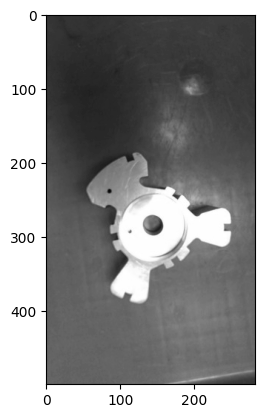

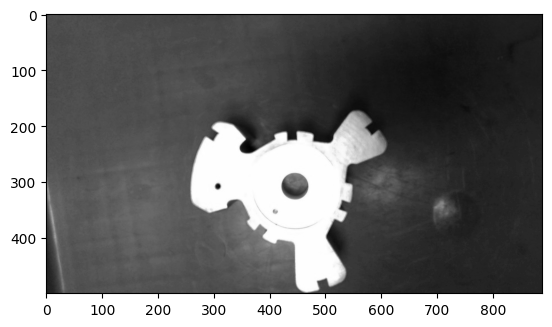

In [4]:
original = rgb2gray(org)
distorted = rgb2gray(dist)
plt.figure()
plt.imshow(original, cmap='gray')
plt.figure()
plt.imshow(distorted, cmap='gray')


In [4]:
descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(original)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(distorted)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [5]:
matches12 = match_descriptors(
    descriptors1, descriptors2, max_ratio=0.6, cross_check=True
)

Text(0.5, 1.0, 'Original Image vs. Flipped Image\n(subset of matches for visibility)')

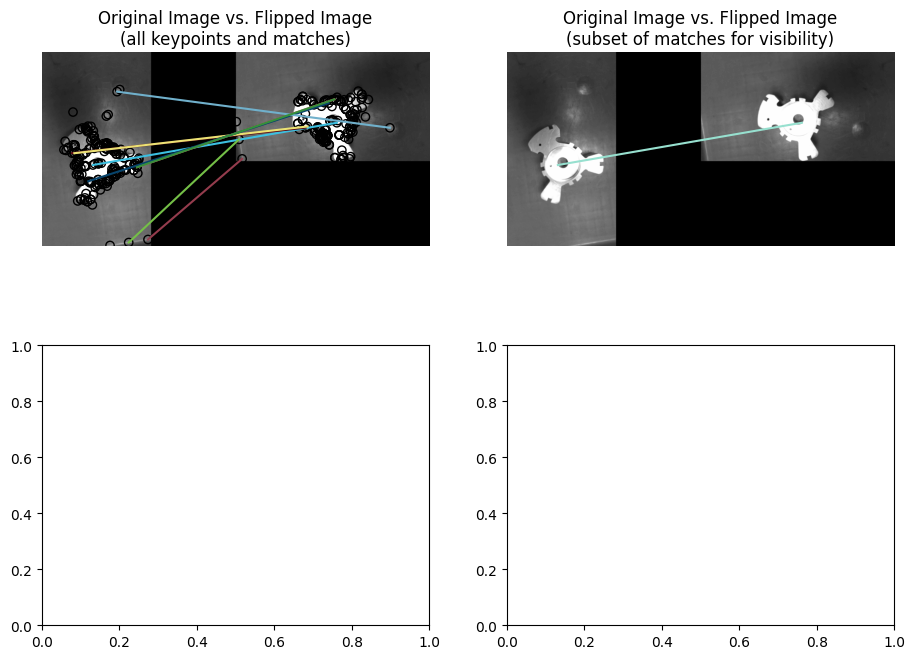

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11, 8))
plt.gray()
plot_matches(ax[0, 0], original, distorted, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n" "(all keypoints and matches)")

plot_matches(
    ax[0, 1], original,distorted, keypoints1, keypoints2, matches12[::15], only_matches=True
)
ax[0, 1].axis('off')
ax[0, 1].set_title(
    "Original Image vs. Flipped Image\n" "(subset of matches for visibility)"
)

In [7]:
featuresOriginal = descriptors1
featuresDistorted = descriptors2

In [8]:
indexPairs = match_descriptors(featuresOriginal, featuresDistorted)

In [9]:
matchedOriginal = keypoints1[indexPairs[:, 0]]
matchedDistorted = keypoints2[indexPairs[:, 1]]

Text(0.5, 1.0, 'Putatively matched points (including outliers)')

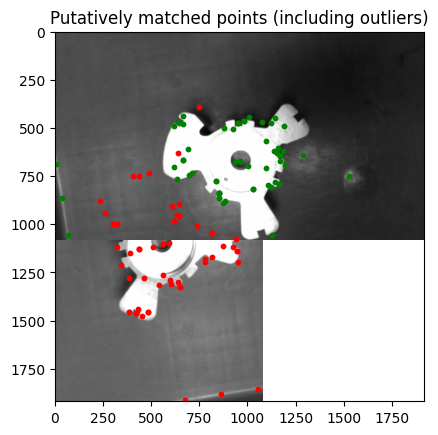

In [10]:
plt.figure()
plt.imshow(original, cmap='gray')
plt.scatter(matchedOriginal[:, 1], matchedOriginal[:, 0], c='r', s=10)
plt.imshow(distorted, cmap='gray')
plt.scatter(matchedDistorted[:, 1], matchedDistorted[:, 0], c='g', s=10)
plt.title('Putatively matched points (including outliers)')

Recovered scale: 1.8864205560617717
Recovered theta: -74.93189070173203


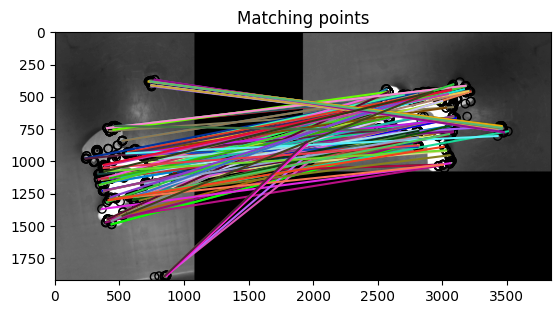

In [20]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, plot_matches, ORB
from skimage.transform import AffineTransform
import matplotlib.pyplot as plt

# Convert images to grayscale
original_gray = original
distorted_gray = distorted 

# Detect ORB keypoints and descriptors
orb = ORB(n_keypoints=500,fast_threshold=0.01)
orb.detect_and_extract(original_gray)
keypoints_original = orb.keypoints
descriptors_original = orb.descriptors

orb.detect_and_extract(distorted_gray)
keypoints_distorted = orb.keypoints
descriptors_distorted = orb.descriptors

# Match features
matches = match_descriptors(descriptors_original, descriptors_distorted, cross_check=True)

# Extract matched keypoints
matched_original = keypoints_original[matches[:, 0]]
matched_distorted = keypoints_distorted[matches[:, 1]]

# Estimate similarity transform
tform = AffineTransform()
tform.estimate(matched_distorted, matched_original)

# Apply transformation to get recovered scale and rotation
scale_recovered = np.sqrt(np.linalg.det(tform.params[0:2, 0:2]))
theta_recovered = np.degrees(np.arctan2(tform.params[0, 1], tform.params[0, 0]))

print('Recovered scale:', scale_recovered)
print('Recovered theta:', theta_recovered)

# Display matching points
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches(ax, original_gray, distorted_gray, keypoints_original, keypoints_distorted, matches)
plt.title('Matching points')
plt.show()


In [6]:
import cv2
import numpy as np


# Convert images to grayscale
original_gray = cv2.normalize(original, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
distorted_gray = cv2.normalize(distorted, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')



# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
keypoints_original, descriptors_original = sift.detectAndCompute(original_gray, None)
keypoints_distorted, descriptors_distorted = sift.detectAndCompute(distorted_gray, None)

# Create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors
matches = bf.knnMatch(descriptors_original, descriptors_distorted, k=2)

# Apply ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
matched_original = np.float32([keypoints_original[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
matched_distorted = np.float32([keypoints_distorted[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Estimate similarity transform
tform, inlier_mask = cv2.estimateAffinePartial2D(matched_distorted, matched_original)

# Apply transformation to get recovered scale and rotation
scale_recovered = np.sqrt(np.linalg.det(tform[0:2, 0:2]))
theta_recovered = -np.degrees(np.arctan2(tform[0, 1], tform[0, 0]))

print('Recovered scale:', scale_recovered)
print('Recovered theta:', theta_recovered)


Recovered scale: 0.9037556108573785
Recovered theta: -141.35867161150287


In [38]:
import cv2
import numpy as np

def find_rotation_angle(original_image, rotated_image):
    # Convert images to grayscale
    original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    rotated_gray = cv2.cvtColor(rotated_image, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create()

    # Detect keypoints and compute descriptors
    keypoints_original, descriptors_original = orb.detectAndCompute(original_gray, None)
    keypoints_rotated, descriptors_rotated = orb.detectAndCompute(rotated_gray, None)

    # Match descriptors using a Brute-Force matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors_original, descriptors_rotated)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Select top matches
    num_matches = 1000
    selected_matches = matches[:num_matches]

    # Get corresponding points
    original_points = np.float32([keypoints_original[match.queryIdx].pt for match in selected_matches]).reshape(-1, 1, 2)
    rotated_points = np.float32([keypoints_rotated[match.trainIdx].pt for match in selected_matches]).reshape(-1, 1, 2)

    # Compute homography
    homography, _ = cv2.findHomography(rotated_points, original_points, cv2.RANSAC)

    # Get rotation angle from homography matrix
    rotation_angle = np.degrees(np.arctan2(homography[0, 1], homography[0, 0]))

    return rotation_angle

# Example usage
original_image = cv2.imread('E:/Mowito/Test_images/org.jpg')
rotated_image = cv2.imread('E:/Mowito/Test_images/dist.jpg')

rotation_angle = find_rotation_angle(original_image, rotated_image)
print("Rotation angle:", rotation_angle)


Rotation angle: -82.72823333823189


In [4]:
import cv2
import numpy as np

# Load the images
image = cv2.imread('./Test_images/org.jpg')
object_to_detect = cv2.imread('./Test_images/org.jpg')

# Convert both images to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_object = cv2.cvtColor(object_to_detect, cv2.COLOR_BGR2GRAY)

# Initialize ORB detector
orb = cv2.ORB_create()

# Find keypoints and descriptors in both images
keypoints_image, descriptors_image = orb.detectAndCompute(gray_image, None)
keypoints_object, descriptors_object = orb.detectAndCompute(gray_object, None)

# Create a brute-force matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Match descriptors of the object to descriptors in the image
matches = bf.match(descriptors_object, descriptors_image)

# Sort the matches based on their distances
matches = sorted(matches, key=lambda x: x.distance)

# Get the keypoints of the matched object
matched_keypoints_image = np.array([keypoints_image[match.trainIdx].pt for match in matches])

# Compute the bounding polygon
bounding_polygon = cv2.convexHull(matched_keypoints_image)

# Draw the polygon on the image
image_with_polygon = cv2.polylines(image.copy(), [np.int32(bounding_polygon)], True, (0, 255, 0), thickness=2)

# Display the image with the polygon
cv2.imshow('Object Detection with Polygon', image_with_polygon)
cv2.waitKey(0)
cv2.destroyAllWindows()



error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\convhull.cpp:143: error: (-215:Assertion failed) total >= 0 && (depth == CV_32F || depth == CV_32S) in function 'cv::convexHull'
